## Generator with Deep Convolutional Generative Adversarial Network (DCGAN)
In this mini project, I would build a generator for handwritten English alphabet letters using a small deep convolutional generative adversarial network (DCGAN). I use the EMNIST Letters dataset (https://www.nist.gov/itl/products-and-services/emnist-dataset, http://arxiv.org/abs/1702.05373). 

Hyperparameters and the network architecture of the model are adopted and modified from the note provided in 'Build Basic GANs' course offered by DeepLearning.AI (https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans).

I load the necessary libraries first. I use PyTorch for the machine learning framework in this mini project.

In [1]:
import torch
import torchvision as tv
from torch import nn
from tqdm import tqdm # for iteration update
import matplotlib.pyplot as plt

### EMNIST dataset
I load the EMNIST Letters dataset through torchvision. In this project, we do not measure the performance of the model quantitatively and therefore we do not divide the dataset into the training set and the test set. For the demonstration of the data set, I present a small sample of images and labels. Each image is a greyscale 28×28 pixels image, and the labels range from 1 to 26 representing 'A' through 'Z'. Note that the labels are case-insensitive for the Letters dataset we use in this project.

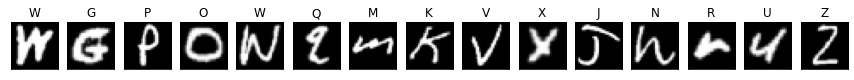

In [2]:
# Transforming the image so that pixel brightness ranges from -1 to 1
transform=tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(0.5,0.5)
])

# Loarding the dataset and presenting sample images in the dataset
emnist=tv.datasets.EMNIST(".","letters",download=False,transform=transform)
n_show_sample=15
plt.figure(figsize=(n_show_sample,1))
letter_label=[chr(64+i) for i in range(27)]
for i in range(n_show_sample):
    img,lbl=emnist.__getitem__(i)
    plt.subplot(1,n_show_sample,i+1)
    img=(img+1)/2
    plt.imshow(torch.transpose(img.view((28,28)),0,1))
    plt.gray(); plt.xticks([]); plt.yticks([]); plt.title(letter_label[lbl])
plt.show()

### DCGAN model
A typical GAN is composed of a generator and a discriminator. In case that the targeting dataset is composed of images, the generator takes the input of a randomized vector and outputs an image similar to the images in the dataset, while the discriminator take the input of an image and outputs a number corresponding to the likelihood of that the input image belongs to that given dataset.

In the DCGAN model in this note, I contruct a geneartor composed of following layers:
1. 2D transposed convolutional layer with 3×3 kernel, followed by batch normalization and ReLU activation
    + zdim-dimensional vector → 4\*hdim-channel 3×3 pixels image
2. 2D transposed convolutional layer with 4×4 kernel, followed by batch normalization and ReLU activation
    + 4\*hdim-channel 3×3 pixels image → 2\*hdim-channel 6×6 pixels image
3. 2D transposed convolutional layer with 3×3 kernel and stride 2, followed by batch normalization and ReLU activation
    + 2\*hdim-channel 6×6 pixels image → hdim-channel 13×13 pixels image
4. 2D transposed convolutional layer with 4×4 kernel and stride 2, followed by Tanh activation
    + hdim-channel 13×13 pixels image → single channel 28×28 pixels image

Here, 'zdim' and 'hdim' are hyperparameters control the size of the network. Note the last layer used Tanh activation to bound the brightness of each pixel.

In [3]:
# Defining the class for generator
class Generator(nn.Module):
    def __init__(self, zdim, hdim):
        super().__init__()
        self.zdim=zdim
        self.seq=nn.Sequential(
            nn.ConvTranspose2d(zdim,hdim*4,3,1),
            nn.BatchNorm2d(hdim*4),nn.ReLU(),
            nn.ConvTranspose2d(hdim*4,hdim*2,4,1),
            nn.BatchNorm2d(hdim*2),nn.ReLU(),
            nn.ConvTranspose2d(hdim*2,hdim,3,2),
            nn.BatchNorm2d(hdim),nn.ReLU(),
            nn.ConvTranspose2d(hdim,1,4,2),
            nn.Tanh(),
        )        
    def forward(self, z):
        # z is the randomized vector
        return self.seq(z.view(len(z),self.zdim,1,1))

The discriminator is composed of the following layers:
1. 2D convolutional layer with 4×4 kernel and stride 2, followed by batch normalization and LeakyReLU activation
    + single channel 28×28 pixels image → hdim-dimensional 13×13 pixels image
2. 2D convolutional layer with 4×4 kernel and stride 2, followed by batch normalization and LeakyReLU activation
    + hdim-dimensional 13×13 pixels image → 2\*hdim-dimensional 5×5 pixels image
3. 2D convolutional layer with 4×4 kernel and stride 2
    + 2\*hdim-dimensional 5×5 pixels image → single real number

In [4]:
# Defining the class for discriminator
class Discriminator(nn.Module):
    def __init__(self, hdim):
        super().__init__()
        self.hdim=hdim
        self.seq=nn.Sequential(
            nn.Conv2d(1,hdim,4,2),
            nn.BatchNorm2d(hdim),nn.LeakyReLU(0.2),
            nn.Conv2d(hdim,hdim*2,4,2),
            nn.BatchNorm2d(hdim*2),nn.LeakyReLU(0.2),
            nn.Conv2d(hdim*2,1,4,2),
        )        
    def forward(self, img):
        pred=self.seq(img)
        return pred.view(len(pred),-1)

Here I set the necessary hyperparameters for the sizes of networks and the optimization. Adam optmizer is used. I also initialize the network.

In [5]:
# Hyperparameters for the network size and optimizer
zdim=64
hdim_g=64
hdim_d=16
learn_rate=0.0002
beta1=0.5
beta2=0.999
device='cpu'

# Instances for the generator, the discriminator, and their optimizers
gen=Generator(zdim,hdim_g).to(device)
disc=Discriminator(hdim_d).to(device)
gen_optimizer=torch.optim.Adam(gen.parameters(), lr=learn_rate, betas=(beta1,beta2))
disc_optimizer=torch.optim.Adam(disc.parameters(), lr=learn_rate, betas=(beta1,beta2))

# Initializing the network
def initialization(layer):
    if (type(layer)==nn.Conv2d) or (type(layer)==nn.ConvTranspose2d):
        nn.init.normal_(layer.weight, 0, 0.02)
    if type(layer)==nn.BatchNorm2d:
        nn.init.normal_(layer.weight, 0, 0.02)
        nn.init.constant_(layer.bias, 0)
gen=gen.apply(initialization)
disc=disc.apply(initialization)

# Binary cross entropy loss function
loss=nn.BCEWithLogitsLoss()

### Model training
To train a GAN, both of the generator and the discriminator should be updated. Yet, since the generator and the discriminator compete each other, they should be updated in the alternating order. To update the generator, we use the binary cross entropy for loss function on the created fake images through the generator with all labels being one (that is, we wish the fake images to deceive the discriminator as much as possible). On the other hand, when updating the discriminator, we use the binary cross entropy again but with the labels to be one for the predictions from the real images and to be zero for the perdictions from the fake images.

I trains this model for 20 epochs with batch size 128. In the course of training, one can see that both losses of the generator and the discriminator converge to $\frac{\sqrt{2}}{2}=-\frac{1}{2}\log_2\frac{1}{2}$. This means that the networks essentially stop to learn, since this is the binary cross entorpy loss for the case when the discriminator always determine the likelihood of the fake image being in the dataset as $1/2$.

100%|██████████| 975/975 [07:55<00:00,  2.05it/s]


epoch  1 : gen_loss= 1.263547819547164 , disc_loss= 0.42077299111928695


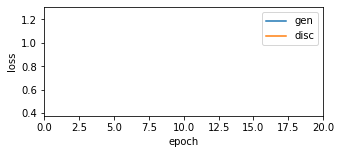

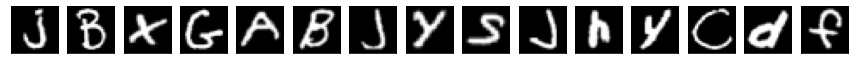

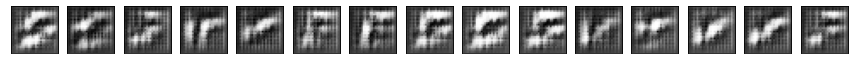

100%|██████████| 975/975 [07:49<00:00,  2.08it/s]


epoch  2 : gen_loss= 1.066578046878179 , disc_loss= 0.5553321055265573


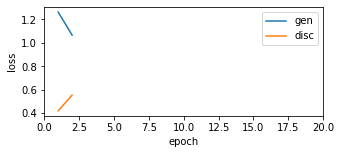

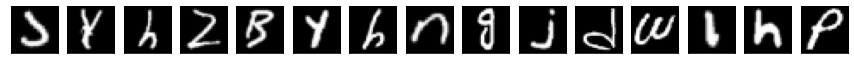

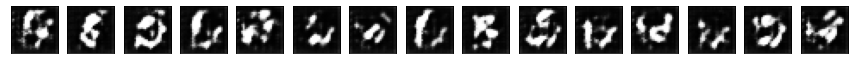

100%|██████████| 975/975 [07:49<00:00,  2.08it/s]


epoch  3 : gen_loss= 0.8737762900804862 , disc_loss= 0.6008433991212111


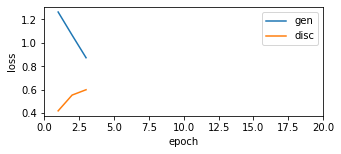

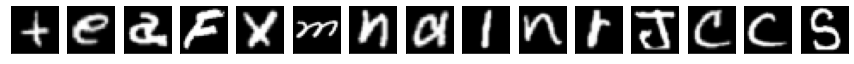

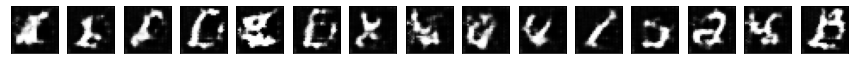

100%|██████████| 975/975 [07:47<00:00,  2.09it/s]


epoch  4 : gen_loss= 0.8166469024083554 , disc_loss= 0.6429614205849477


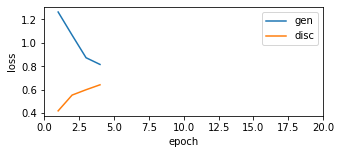

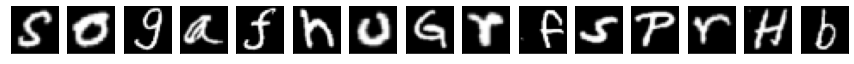

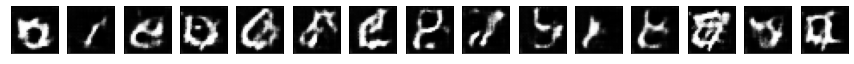

100%|██████████| 975/975 [07:52<00:00,  2.06it/s]


epoch  5 : gen_loss= 0.7548423462953323 , disc_loss= 0.6746161555021237


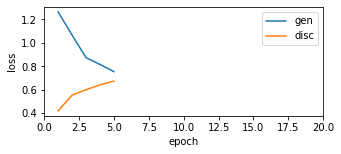

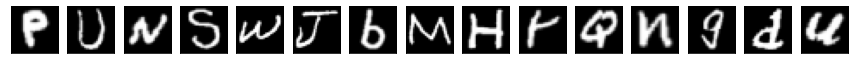

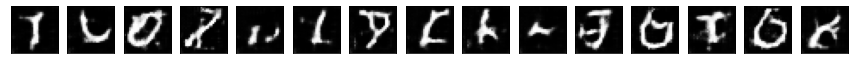

100%|██████████| 975/975 [07:49<00:00,  2.08it/s]


epoch  6 : gen_loss= 0.7386194100746741 , disc_loss= 0.6864826700626275


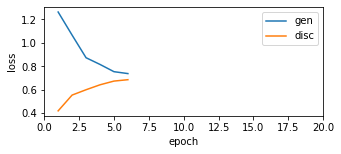

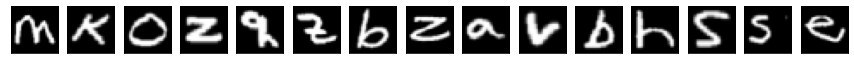

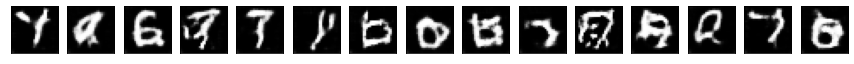

100%|██████████| 975/975 [07:51<00:00,  2.07it/s]


epoch  7 : gen_loss= 0.7351634672666207 , disc_loss= 0.6891976484885582


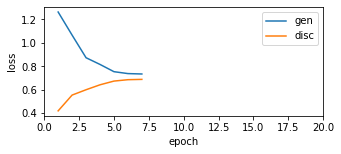

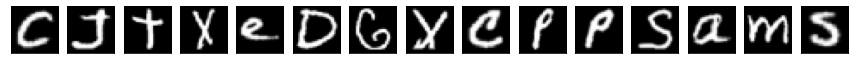

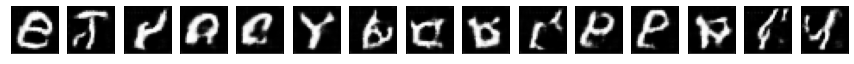

100%|██████████| 975/975 [07:49<00:00,  2.08it/s]


epoch  8 : gen_loss= 0.7311844933949984 , disc_loss= 0.690398296270615


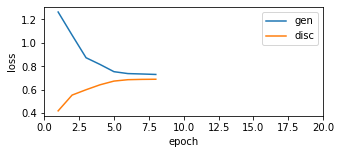

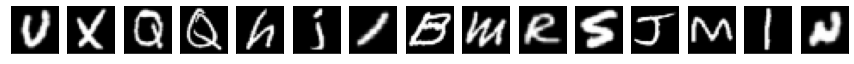

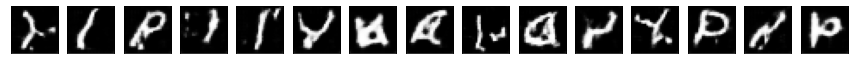

100%|██████████| 975/975 [07:56<00:00,  2.04it/s]


epoch  9 : gen_loss= 0.7244695475162604 , disc_loss= 0.6925721627626663


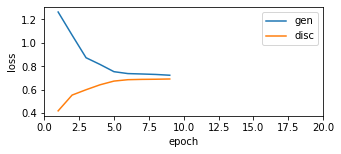

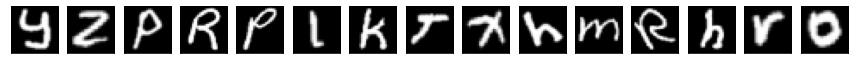

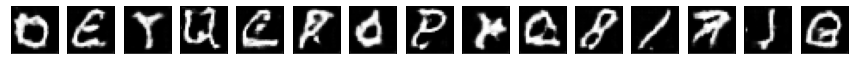

100%|██████████| 975/975 [07:45<00:00,  2.09it/s]


epoch  10 : gen_loss= 0.7208853351458525 , disc_loss= 0.6935879476865132


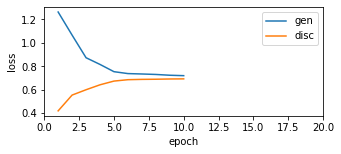

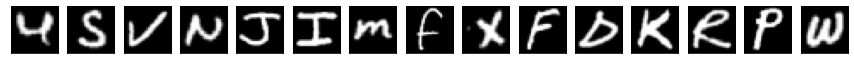

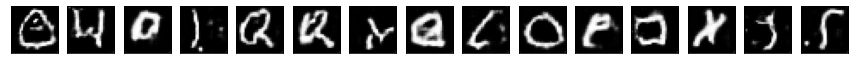

100%|██████████| 975/975 [07:52<00:00,  2.06it/s]


epoch  11 : gen_loss= 0.7152778277030358 , disc_loss= 0.6940906395056309


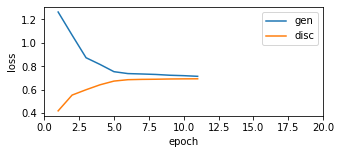

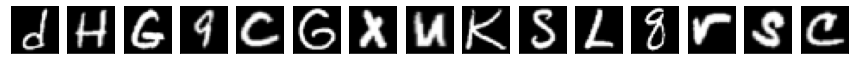

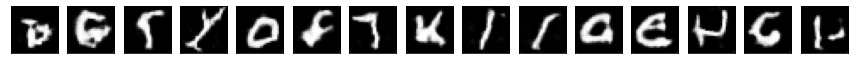

100%|██████████| 975/975 [07:57<00:00,  2.04it/s]


epoch  12 : gen_loss= 0.7127896735301384 , disc_loss= 0.6947147212273035


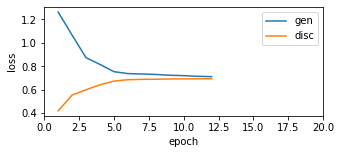

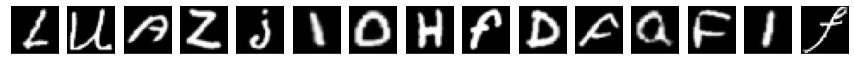

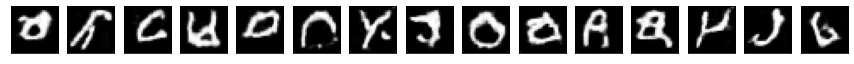

100%|██████████| 975/975 [07:51<00:00,  2.07it/s]


epoch  13 : gen_loss= 0.7101101742340968 , disc_loss= 0.6954402847167773


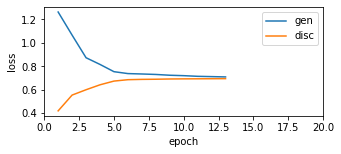

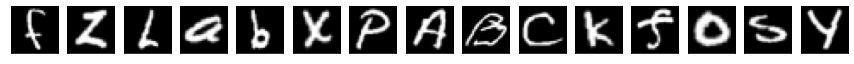

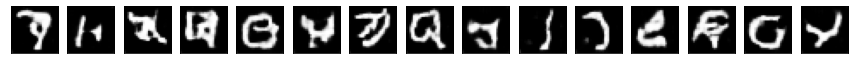

100%|██████████| 975/975 [07:58<00:00,  2.04it/s]


epoch  14 : gen_loss= 0.7084628141232026 , disc_loss= 0.6954853455836957


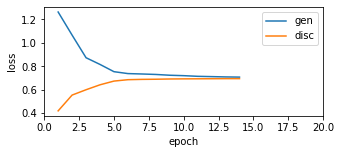

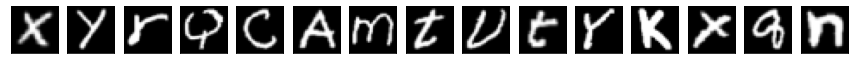

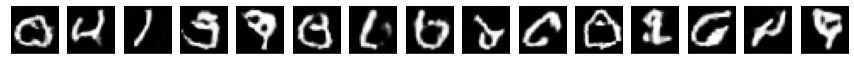

100%|██████████| 975/975 [07:46<00:00,  2.09it/s]


epoch  15 : gen_loss= 0.7059359650122814 , disc_loss= 0.6959600853308653


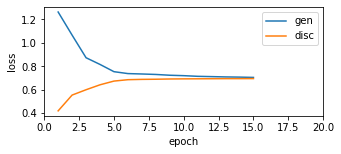

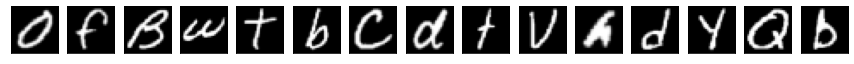

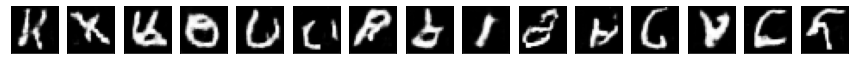

100%|██████████| 975/975 [07:55<00:00,  2.05it/s]


epoch  16 : gen_loss= 0.7038947551067058 , disc_loss= 0.6962014867709233


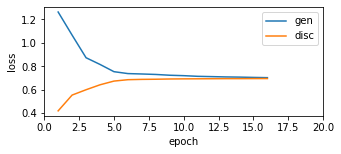

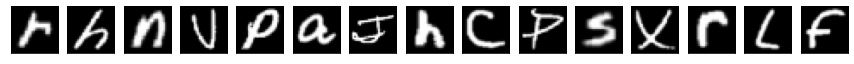

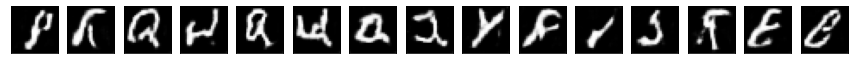

100%|██████████| 975/975 [07:47<00:00,  2.08it/s]


epoch  17 : gen_loss= 0.7011724344889323 , disc_loss= 0.6958287578974015


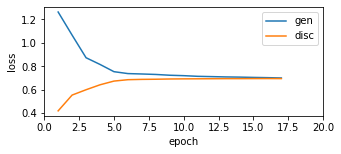

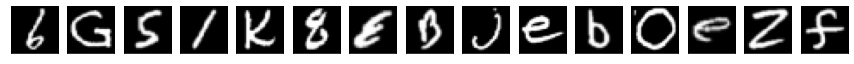

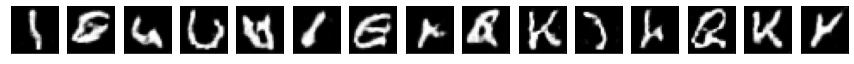

100%|██████████| 975/975 [07:43<00:00,  2.11it/s]


epoch  18 : gen_loss= 0.7001086850044055 , disc_loss= 0.6957082860286419


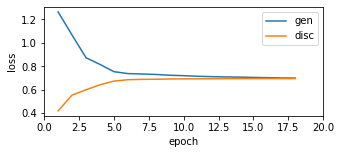

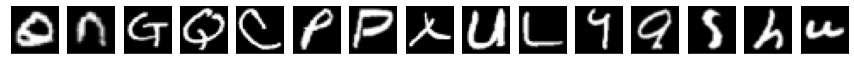

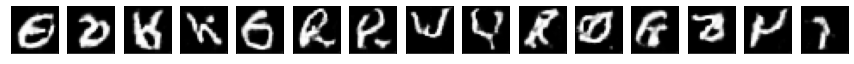

100%|██████████| 975/975 [07:41<00:00,  2.11it/s]


epoch  19 : gen_loss= 0.6999933294149545 , disc_loss= 0.6957006727120815


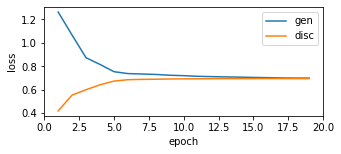

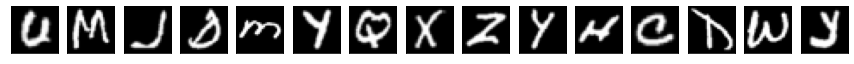

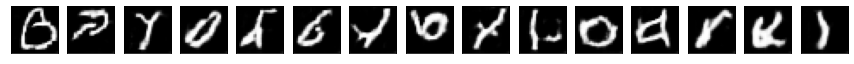

100%|██████████| 975/975 [07:55<00:00,  2.05it/s]


epoch  20 : gen_loss= 0.6998087944739905 , disc_loss= 0.6953907978840363


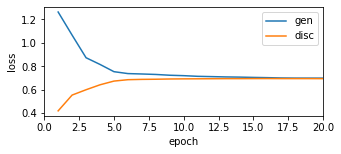

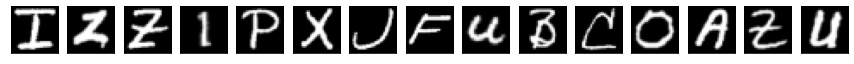

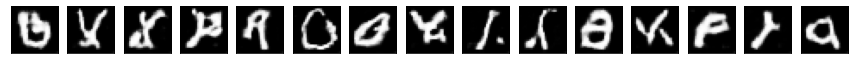

In [6]:
# Batch size and number of epochs to proceed training
n_epoch=20
batch_size=128
n_dataset=len(emnist)

dataloader=torch.utils.data.DataLoader(emnist,batch_size=batch_size,shuffle=True)

# storing the loss history every epoch during the training
loss_history=[]

# Training
for epoch in range(n_epoch):
    gen_loss_sum=0
    disc_loss_sum=0
    for real_img,_ in tqdm(dataloader):
        real_img=real_img.to(device)
        
        # updating discriminator
        disc_optimizer.zero_grad()
        z=torch.randn(len(real_img),zdim,device=device)
        fake_img=gen(z)
        fake_pred=disc(fake_img.detach()) # detachment is needed for not updating the generator
        real_pred=disc(real_img)
        disc_loss=(loss(fake_pred,torch.zeros_like(fake_pred))+loss(real_pred,torch.ones_like(fake_pred)))/2
        disc_loss_sum+=disc_loss.item()
        disc_loss.backward()
        disc_optimizer.step()
        
        # updating generator
        gen_optimizer.zero_grad()
        z=torch.randn(len(real_img),zdim,device=device)
        fake_img=gen(z)
        fake_pred=disc(fake_img)
        gen_loss=loss(fake_pred,torch.ones_like(fake_pred))
        gen_loss_sum+=gen_loss.item()
        gen_loss.backward()
        gen_optimizer.step()
        
    # storing the loss
    gen_loss_sum*=(batch_size/n_dataset); disc_loss_sum*=(batch_size/n_dataset)
    loss_history.append([gen_loss_sum,disc_loss_sum])
    
    # plotting the loss history
    plt.figure(figsize=(5,2)); plt.xlim(0,n_epoch); plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(range(1,epoch+2),loss_history); plt.legend(['gen','disc'])
    print("epoch ",epoch+1,": gen_loss=",gen_loss_sum,", disc_loss=",disc_loss_sum)
    real_img=(real_img+1)/2; real_img=real_img.detach().cpu()
    plt.figure(figsize=(n_show_sample,1))
    for i in range(n_show_sample):
        plt.subplot(1,n_show_sample,i+1); plt.xticks([]); plt.yticks([]); plt.gray()
        plt.imshow(torch.transpose(real_img[i].view((28,28)),0,1))
    plt.show()
    fake_img=(fake_img+1)/2; fake_img=fake_img.detach().cpu()
    plt.figure(figsize=(n_show_sample,1))
    for i in range(n_show_sample):
        plt.subplot(1,n_show_sample,i+1); plt.xticks([]); plt.yticks([])
        plt.imshow(torch.transpose(fake_img[i].view((28,28)),0,1))
    plt.show()

After training the model, both of the generator and the discriminator are stored for later uses.

In [7]:
torch.save(gen,"./dcgan_emnist_gen.pt")
torch.save(disc,"./dcgan_emnist_disc.pt")

### Generated images through the model
Although the losses of the generator and the discriminator converge to $\frac{\sqrt{2}}{2}$, it does not mean that the generator can fully regenerate the images in the dataset. To see if the generator is working well, I presented a sample of created images.

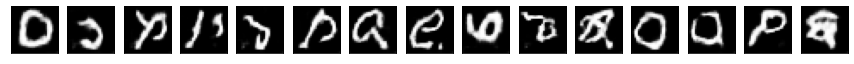

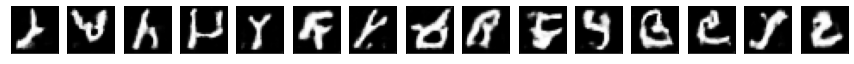

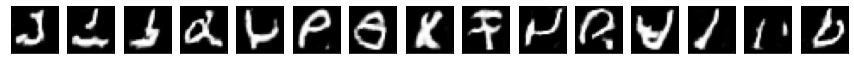

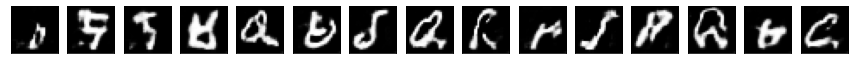

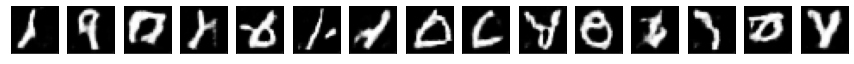

In [8]:
n_img=75 # number of images to present
z=torch.randn(n_img,zdim,device=device)
sample_img=gen(z); sample_img=(sample_img+1)/2; sample_img=sample_img.detach().cpu()
for i in range(n_img):
    if i%n_show_sample==0:
        plt.figure(figsize=(n_show_sample,1))
    plt.subplot(1,n_show_sample,i%n_show_sample+1); plt.xticks([]); plt.yticks([]); plt.gray()
    plt.imshow(torch.transpose(sample_img[i].view((28,28)),0,1))
    if i%n_show_sample==(n_show_sample-1):
        plt.show()

As seen in the sample, most of generated images are not quite like the handwritten alphabet characters. To quantitatively track the accuracy of the model, one may try to calculate Frechet inception distance (FID) or inception score (IS). 